![msp](https://msdnshared.blob.core.windows.net/media/2016/11/Microsoft_Student_Partner2.jpg)

# Parkinson's Disease Challenge

Now that we finished our first challenge, go on and try to predict parkinson's disease from speech samples. 
The structure is similar to our spoken-digit-dataset. However, some adjustments still need to be done. 

** Note: ** Make sure that your dataset is in the correct folder - if there´s something not working for you, feel free to ask.

* 6617 recordings in total
* 8kHz sampling rate
* 1322 speakers
* English 
* File format: {parkinson's\_label}\_{speaker\_id}\_{index}.wav <br> (e.g. "0\_10\_202.wav")
* 0 = no parkinson's, 1 = parkinson's



## Setup & Data Import


In [1]:
# Import the relevant modules to be used later
import glob
import os
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

# Config matplotlib for inline plotting
%matplotlib inline

In [2]:
# Dataset directory
DATASET_DIR = "dataset/"

# Create a list of all .wav files in the dataset directoy paths 
sound_paths = [DATASET_DIR + f for f in os.listdir(DATASET_DIR) if f[-4:] == '.wav']

## Data Exploration

Let's visualize different sound files. 

In [6]:
# Helper methods for our data import

def plot_wave(sound_filenames):
    plt.figure(figsize=(15, 2 * len(sound_filenames)))
    i = 1
    for filename in sound_filenames:
        data, sample_rate = librosa.load(DATASET_DIR + filename)
        digit_caption = "Has PD " + os.path.basename(filename)[0]
        
        plt.subplot(np.ceil(float(len(sound_filenames))/2), 2, i)
        librosa.display.waveplot(np.array(data),sr=sample_rate)
        i += 1
        plt.ylabel('Amplitude')
        plt.title(digit_caption)
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()
    
def plot_spectrogram(sound_filenames):
    i = 1
    plt.figure(figsize=(15, 2 * len(sound_filenames)))
    for filename in sound_filenames:
        data, sample_rate = librosa.load(DATASET_DIR + filename)
        digit_caption = "Has PD: " + os.path.basename(filename)[0]
        
        plt.subplot(np.ceil(float(len(sound_filenames))/2), 2, i)
        
        # Plot FFT spectrogram
        # fft = librosa.stft(data, n_fft=256)
        # librosa.display.specshow(librosa.amplitude_to_db(fft,ref=np.max),y_axis='log', x_axis='time')
        
        # Plot MEL spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128, fmax=8000)
        print('lib:' + str(librosa.power_to_db(mel_spectrogram,ref=np.max).shape))
        librosa.display.specshow(librosa.power_to_db(mel_spectrogram,ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        
        plt.title(digit_caption)
        i += 1
    plt.subplots_adjust(top=0.8, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

In [7]:
# Target sound filenames for visualization
sound_filenames = []
sound_filenames.append('0_0.wav')
sound_filenames.append('1_3.wav')

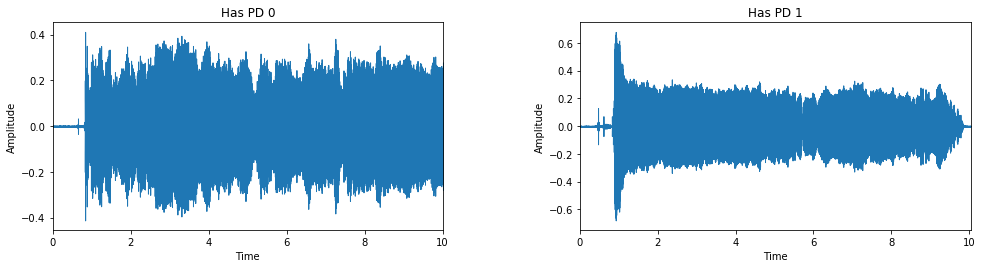

In [8]:
# Visualize wave files
plot_wave(sound_filenames)

lib:(128, 432)
lib:(128, 433)


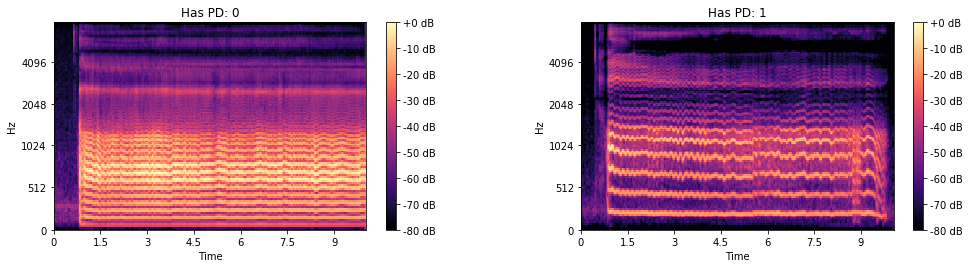

In [9]:
# Plot spectogram
plot_spectrogram(sound_filenames)

## Feature Extraction

First, we will extract our features from the audio files. Two files will be generated - one for the features and one for the corresponding labels. Each line in our feature-label-pair will represent a single audio file.

### MFCC
[Mel Frequency Cepstral Coefficients](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) 

In [18]:
# Number of mel filters we want to extract 
# A higher number indicates a higher resolution of our signal - however, this
# means that we need to train more parameters
# 20 - 40 is used in most cases
n_mels = 30
max_pad_len=40

def extract_features(file_name):
    data, sample_rate = librosa.load(file_name)
        
    wave = data[::3]
    melgram = librosa.feature.melspectrogram(wave, sr=sample_rate, n_mels=n_mels)
    pad_width = max_pad_len - melgram.shape[1]
    melgram = np.pad(melgram, pad_width=((0, 0), (0, pad_width)), mode='constant')

    features = np.hstack((melgram))
    return features

def get_features_and_labels(sound_paths):
    features = None
    labels = np.empty(0)
    for p in sound_paths:
        ext_features = extract_features(p)

        if features is None:
            features = np.empty((0,len(ext_features)))
            
        features = np.vstack([features,ext_features])
        
        labels = np.append(labels, int(os.path.basename(p)[0]))
    return np.array(features), np.array(labels, dtype = np.int)

In [19]:
features, labels = get_features_and_labels(sound_paths)

### One-hot encoding:


In [20]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [21]:
labels = one_hot_encode(labels)

### Save Processed Data

In [22]:
FEATURE_PATH = 'features/features.txt'
LABEL_PATH = 'features/labels.txt'

In [24]:
np.savetxt(FEATURE_PATH, features, fmt='%10.5f', delimiter='\t')
np.savetxt(LABEL_PATH, labels, fmt='%i', delimiter='\t')

## Classification

Now, we will load our generated features and labels in order to train a classifier on it and evaluate its performance. 

In [25]:
import random
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.initializers import lecun_uniform
from keras import optimizers
from keras.layers import Dense, Dropout, Activation, LSTM
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_fscore_support)

C:\Users\Henry\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading data
Before building the network, we will load the stored data and split the data into three distinct samples: train, test, and eval. 
![Split Expl](https://image.slidesharecdn.com/dbm630-lecture08-120208003610-phpapp01/95/dbm630-lecture08-11-728.jpg?cb=1328661419)

In [26]:
features = np.loadtxt(FEATURE_PATH)
labels = np.loadtxt(LABEL_PATH)

print('Label shape: ' + str(labels.shape))
feature_dim = features.shape[1]
print('Feature dimensions: ' + str(feature_dim))

Label shape: (1044, 2)
Feature dimensions: 5800


In [27]:
# Splits our whole dataset in three parts for training, testing, and evaluating our model
def split_train_test_eval (features, labels, train_percentage, test_percentage, eval_percentage):
    feature_label_pairs = list(zip(features, labels))
    random.shuffle(feature_label_pairs)
    features, labels = zip(*feature_label_pairs)
    features = np.array(features)
    labels = np.array(labels)
    
    sample_size = len(labels)
    print('Number of total samples: ' + str(sample_size))
    
    train_samples = int(sample_size * train_percentage)
    test_samples = int(sample_size * test_percentage)
    eval_samples = int(sample_size * eval_percentage)
    
    # just to make sure that we end up with the actual sample size:
    if train_samples + test_samples + eval_samples > sample_size:
        eval_samples = sample_size - train_samples - test_samples
    
    print('Train sample size: ' + str(train_samples))
    print('Test sample size: ' + str(test_samples))
    print('Eval sample size: ' + str(eval_samples))
    
    train_features = features[0 : train_samples]
    train_labels = labels[0 : train_samples]
    
    test_features = features[train_samples : train_samples + test_samples]
    test_labels = labels[train_samples : train_samples + test_samples]
    
    eval_features = features[train_samples + test_samples : train_samples + test_samples + eval_samples]
    eval_labels = labels[train_samples + test_samples : train_samples + test_samples + eval_samples]
    
    return train_features, train_labels, test_features, test_labels, eval_features, eval_labels


In [28]:
   
train_features, train_labels, test_features, test_labels, eval_features, eval_labels = split_train_test_eval (features, labels, 0.5, 0.3, 0.2)
testing = (test_features, test_labels)
evaluation = (eval_features, eval_labels)

Number of total samples: 1044
Train sample size: 522
Test sample size: 313
Eval sample size: 208


### Building our first model

Let's try it with a DNN with 3 hidden layers
![dnn](https://camo.githubusercontent.com/82b7fff72d1c4da37e0c4474bfd0cdd06b1a6a75/687474703a2f2f74656c656772612e70682f66696c652f3137356133343032346263343536353164306265362e706e67)


Defining the network achitecture

In [39]:
model = Sequential()
model.add(Dense(units=500, input_dim=feature_dim, activation="relu"))
model.add(Dense(units=300,activation="relu"))
model.add(Dense(units=20, activation="relu"))
model.add(Dense(units=2,activation="sigmoid"))

Training the model:
1. Define the optimizer
2. Compile the the defined model
3. Train it

In [40]:
opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

model.fit(train_features,train_labels, validation_data=evaluation, epochs=10, batch_size=16)



MODEL_DIR = "models/model1.model"

model.save(MODEL_DIR)

Train on 522 samples, validate on 208 samples
Epoch 1/10
522/522 [==============================] - 1s 3ms/step - loss: 1.6416 - acc: 0.5354 - val_loss: 0.6915 - val_acc: 0.6154
Epoch 2/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6906 - acc: 0.6159 - val_loss: 0.6880 - val_acc: 0.6154
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6867 - acc: 0.6169 - val_loss: 0.6855 - val_acc: 0.6154
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6846 - acc: 0.6169 - val_loss: 0.6837 - val_acc: 0.6154
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6829 - acc: 0.6169 - val_loss: 0.6822 - val_acc: 0.6154
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6815 - acc: 0.6169 - val_loss: 0.6810 - val_acc: 0.6154
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6804 - acc: 0.6169 - val_loss: 0.6800 - val_acc: 0.6154
Epoch 8/10
522/522 [==========

Score the model

In [42]:
prediction_probabilities = np.array(model.predict_proba(test_features))
prediction = np.array(model.predict_classes(test_features))
                                            
test_classes = np.argmax(test_labels, axis=1)
print(prediction)
print(test_classes)

accuracy = accuracy_score(test_classes, prediction)
print('Accuracy: ' + str(accuracy))

conf_mat = confusion_matrix(test_classes, prediction).T
print(conf_mat)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1
 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1

### The next level
Lets build a simple LSTM powered network.

![lstm](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

Reshape the data

In [51]:
print(train_features.shape)
train_features = train_features.reshape((len(train_features), 1, 5800))
test_features = test_features.reshape((len(test_features), 1, 5800))
print(train_features.shape)

(522, 1, 5800)
(522, 1, 5800)


Define the network architecture

In [53]:

# Neural network with LSTM


model = Sequential()
model.add(LSTM(300, input_shape=(1, 5800)))
model.add(Dropout(0.5))
model.add(Dense(2))



Train the network

In [55]:
model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=["accuracy"])

model.fit(train_features, train_labels, epochs=20, batch_size=10, verbose=2)

Epoch 1/20
 - 11s - loss: 0.5048 - acc: 0.5402
Epoch 2/20
 - 10s - loss: 0.3964 - acc: 0.5843
Epoch 3/20
 - 10s - loss: 0.3014 - acc: 0.6130
Epoch 4/20
 - 10s - loss: 0.2872 - acc: 0.6188
Epoch 5/20
 - 10s - loss: 0.2927 - acc: 0.6264
Epoch 6/20
 - 10s - loss: 0.2488 - acc: 0.6322
Epoch 7/20
 - 11s - loss: 0.2404 - acc: 0.6398
Epoch 8/20
 - 11s - loss: 0.2153 - acc: 0.6897
Epoch 9/20
 - 10s - loss: 0.2180 - acc: 0.6820
Epoch 10/20
 - 11s - loss: 0.2046 - acc: 0.6992
Epoch 11/20
 - 10s - loss: 0.2119 - acc: 0.6916
Epoch 12/20
 - 11s - loss: 0.2030 - acc: 0.7222
Epoch 13/20
 - 10s - loss: 0.2049 - acc: 0.6877
Epoch 14/20
 - 11s - loss: 0.1945 - acc: 0.7146
Epoch 15/20
 - 10s - loss: 0.1978 - acc: 0.7050
Epoch 16/20
 - 10s - loss: 0.1986 - acc: 0.7241
Epoch 17/20
 - 10s - loss: 0.2071 - acc: 0.6992
Epoch 18/20
 - 10s - loss: 0.1987 - acc: 0.7107
Epoch 19/20
 - 10s - loss: 0.1979 - acc: 0.7088
Epoch 20/20
 - 10s - loss: 0.1840 - acc: 0.7165


Score model

In [58]:
# reshape for lstm
prediction_probabilities = np.array(model.predict_proba(test_features))
prediction = np.array(model.predict_classes(test_features))
                                            
test_classes = np.argmax(test_labels, axis=1)
print(prediction)
print(test_classes)

accuracy = accuracy_score(test_classes, prediction)
print('Accuracy: ' + str(accuracy))

conf_mat = confusion_matrix(test_classes, prediction)
print(conf_mat)

import pandas as pd
pd.crosstab(test_classes, prediction, rownames=['True'], colnames=['Predicted'], margins=True)

C:\Users\Henry\Anaconda3\lib\site-packages\keras\engine\sequential.py:252: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


[1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1
 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1
 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0
 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1
 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1

Predicted,0,1,All
True,,,
0,25,94,119
1,28,166,194
All,53,260,313
